In [ ]:
# GAOL2

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark Session
spark = SparkSession.builder.appName("Identifying Underpriced Cars").getOrCreate()
# Load the data
df = spark.read.csv('output.csv', header=True, inferSchema=True)
# Data cleaning and preparation
df = df.withColumn('Mileage', regexp_replace('Mileage', ' kmpl| km/kg', '').cast('float'))
df = df.withColumn('Engine', regexp_replace('Engine', ' CC', '').cast('int'))
df = df.withColumn('Power', regexp_replace('Power', ' bhp', '').cast('float'))
# Handle missing values
df = df.na.drop(subset=['Mileage', 'Engine', 'Power', 'Price'])
# Feature Engineering: Encoding categorical variables
stringIndexer = StringIndexer(inputCols=['Fuel_Type', 'Transmission', 'Owner_Type'], 
                              outputCols=['Fuel_Type_Indexed', 'Transmission_Indexed', 'Owner_Type_Indexed'])
oneHotEncoder = OneHotEncoder(inputCols=['Fuel_Type_Indexed', 'Transmission_Indexed', 'Owner_Type_Indexed'], 
                               outputCols=['Fuel_Type_Vec', 'Transmission_Vec', 'Owner_Type_Vec'])
# Assembling all features into a single vector
assembler = VectorAssembler(inputCols=['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 
                                       'Fuel_Type_Vec', 'Transmission_Vec', 'Owner_Type_Vec'], 
                            outputCol="features")
# Random Forest Regression Model
rf = RandomForestRegressor(featuresCol="features", labelCol="Price")
# Pipeline
pipeline = Pipeline(stages=[stringIndexer, oneHotEncoder, assembler, rf])
# Split the data into training and test sets
trainData, testData = df.randomSplit([0.8, 0.2])
# Fit the model
model = pipeline.fit(trainData)
# Make predictions
predictions = model.transform(testData)
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")
# Identifying underpriced cars
underpriced_cars = predictions.withColumn("Price_Difference", col("Price") - col("prediction"))
underpriced_cars = underpriced_cars.filter(col("Price_Difference") > 0).select("Name", "Year", "Price", "prediction", "Price_Difference")
# Save underpriced cars to CSV
underpriced_cars.write.option("header", "true").mode("overwrite").csv("underpriced_cars.csv")
# Save the DataFrame to a CSV file
predictions.withColumn("Price_Difference", predictions["Price"] - predictions["prediction"]) \
    .select("Name", "Year", "Price", "prediction", "Price_Difference") \
    .coalesce(1) \
    .write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("underpriced_cars_output.csv")

Root Mean Squared Error (RMSE) on test data: 6.180814235214958


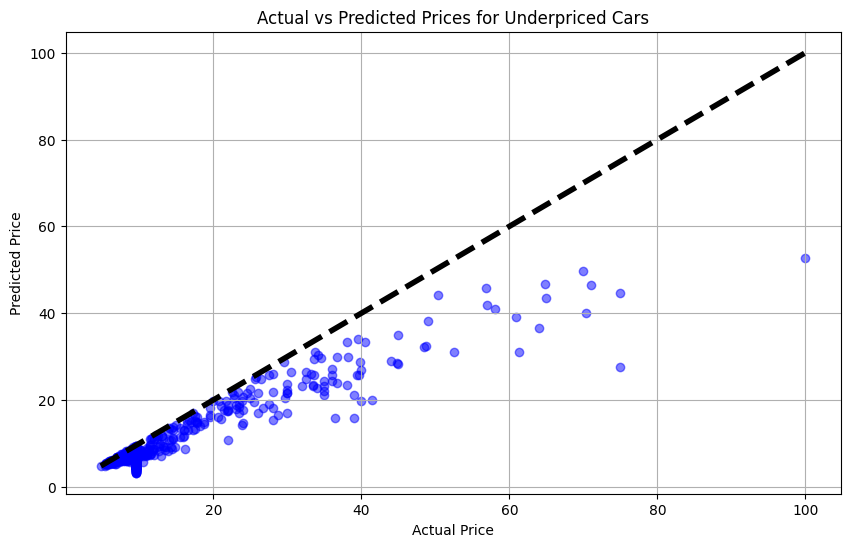

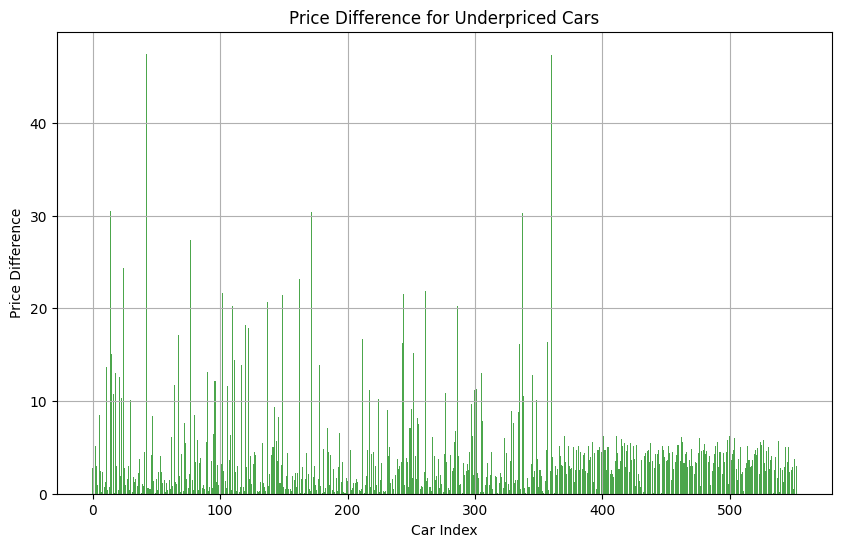

In [14]:
import matplotlib.pyplot as plt

# Extracting data from the DataFrame
price_actual = [row[0] for row in underpriced_cars.select('Price').collect()]
price_predicted = [row[0] for row in underpriced_cars.select('prediction').collect()]
price_difference = [row[0] for row in underpriced_cars.select('Price_Difference').collect()]

# Plotting the predicted price against the actual price
plt.figure(figsize=(10, 6))
plt.scatter(price_actual, price_predicted, color='blue', alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Underpriced Cars')
plt.plot([min(price_actual), max(price_actual)], 
         [min(price_actual), max(price_actual)], 'k--', lw=4)  # Line showing perfect predictions
plt.grid(True)
plt.show()

# Plotting the price difference
plt.figure(figsize=(10, 6))
plt.bar(range(len(price_difference)), price_difference, color='green', alpha=0.7)
plt.xlabel('Car Index')
plt.ylabel('Price Difference')
plt.title('Price Difference for Underpriced Cars')
plt.grid(True)
plt.show()


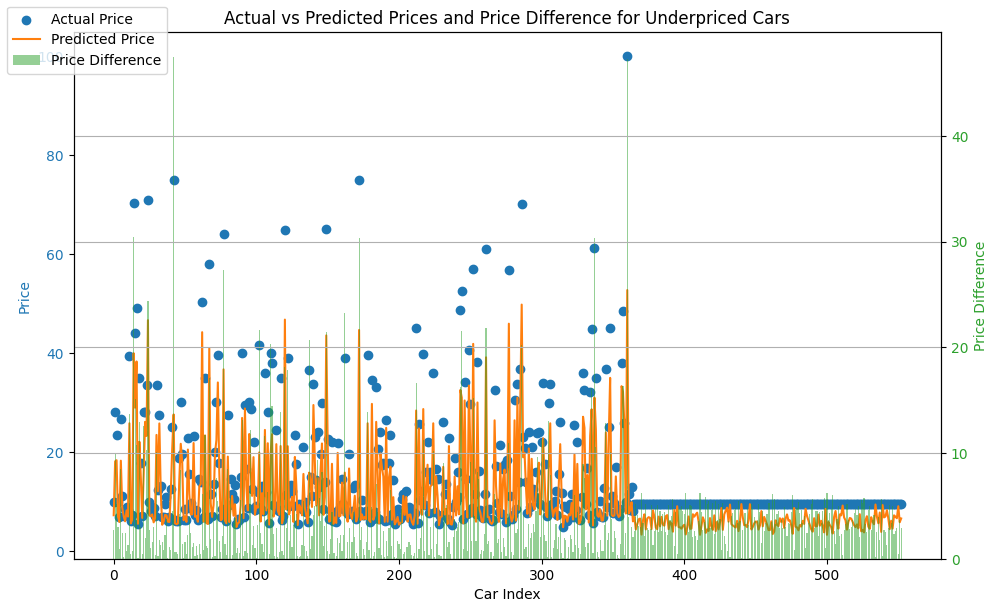

In [15]:
import matplotlib.pyplot as plt

# Extracting data from the DataFrame
price_actual = [row[0] for row in underpriced_cars.select('Price').collect()]
price_predicted = [row[0] for row in underpriced_cars.select('prediction').collect()]
price_difference = [row[0] for row in underpriced_cars.select('Price_Difference').collect()]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Car Index')
ax1.set_ylabel('Price', color=color)
ax1.scatter(range(len(price_actual)), price_actual, color=color, label='Actual Price')
ax1.plot(price_predicted, color='tab:orange', label='Predicted Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Price Difference', color=color)
ax2.bar(range(len(price_difference)), price_difference, color=color, alpha=0.5, label='Price Difference')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left')
plt.title('Actual vs Predicted Prices and Price Difference for Underpriced Cars')
plt.grid(True)
plt.show()
